<a href="https://colab.research.google.com/github/nachozobian/neural-network-pytorch-classification/blob/main/nn_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification with PyTorch

This notebook is a neural classification project using a toy dataset.

In [1]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

#Create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 14)

In [2]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], 
                        "X2":X[:,1],
                        "label": y})

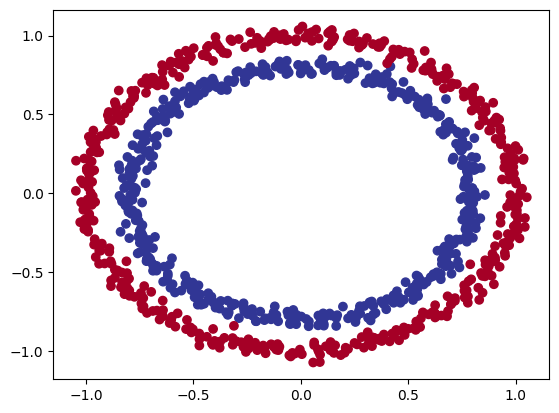

In [3]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y,
            cmap = plt.cm.RdYlBu);

When working on classification we're solving problems like this upper one! We'll practice the fundamentals with a dataset small enough
to practice the fundamentals. 

In the upper problem we're trying to decide whether the point belongs to the first or second ring.

### Turn data into tensors

In [4]:
import torch
torch.__version__

'2.0.0+cu118'

In [5]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

### Split data into train and test set

In [6]:
from sklearn.model_selection import train_test_split
#Using train_test_split is the easier way.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, # 20% test
                                                    random_state = 14)

## Build a model

1. Setup device for training our model (we might to use a GPU)
2. Construct a model (by subclassing 'nn.Module')
3. Define a loss function and optimizer
4. Training and test loop

####1. Setup device for training our model. If there is a GPU available use a GPU 

In [7]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

####2. Construct a model.

In [8]:
class CircleModel0(nn.Module):
  def __init__(self):
    super().__init__()
    # Our model will have 2 Linear layers.
    self.layer_1 = nn.Linear(in_features=2, out_features=5) #In-features has to be 2
    self.layer_2 = nn.Linear(in_features=5, out_features=1) #Outputs a single feature
  
  def forward(self, x):
    return self.layer_2(self.layer_1(x))

#Instanciate an instance of our model
model_0 = CircleModel0().to(device)
model_0

CircleModel0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [9]:
# Replicate the model above using nn.Sequential (easier)
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
#Make prediction with the initial random parameters of our untrained neural network
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \m{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels: \m{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: \mtensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [1.],
        [0.]])

First 10 labels: \mtensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 1.])


####3. Defining a loss function and optimizer.

For regression typically you want MAE or MSE but for a classification problem you'll be more likely to use binary cross entropy. A loss function measures how wrong your predictions are. This information is used by the algorithm to train itself! So it's important to know what loss function to use, this is problem specific and requires experience. 

For optimizers, SGD and Adam are the most common. Anyway PyTorch has many built-in options.

For the loss function we'll use `torch.nn.BECWithLogitsLoss()` which will help us using the binary cross entropy in a classification problem!

In [11]:
#Setup the loss funciton.
# loss_fn = nn.BCELoss() #requires inputs to have gone through the sigmoid activation prior to input BCELoss
loss_fn = nn.BCEWithLogitsLoss() #This loss fn combines the sigmoid with the BCE for us!! 

**NOTE:** According to PyTorch docs "this version of BCELoss is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability"

In [13]:
#We'll just use Stochastic Gradient Descent for this first example. Using Adam would be similar
optimizer = torch.optim.SGD(params= model_0.parameters(),
                           lr = 0.1) 

In [15]:
#Calculating accuracy -> (percentage)
def accuracy_fnc(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred)*100
  return acc